In [13]:
%pip install -qU langchain-text-splitters

Note: you may need to restart the kernel to use updated packages.


In [14]:
!pip install langchain

In [15]:
!pip install cdlib

In [16]:
!pip install pymupdf

In [17]:
# Install required packages
!pip install ollama pandas networkx matplotlib tqdm -q

In [18]:
# Install Ollama
!sudo apt-get install -y pciutils
!curl -fsSL https://ollama.com/install.sh | sh

'sudo' is not recognized as an internal or external command,
operable program or batch file.
'sh' is not recognized as an internal or external command,
operable program or batch file.


In [19]:
# Importing all the necessary libraries
import fitz
import json
import os
import threading
import subprocess
from langchain.text_splitter import RecursiveCharacterTextSplitter
import ollama
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from collections import Counter, defaultdict
import pandas as pd
from cdlib import algorithms
import numpy as np

In [20]:
%cd C:/Users/trifo/Desktop/GitHub Clone/NLP_Assignment

C:\Users\trifo\Desktop\GitHub Clone\NLP_Assignment


Data Processing with LLMs

Implement local or cloud-based Large Language Models (LLMs) to:





*   Extract and structure relevant market data
*   Identify network relationships between entities
*   Perform named entity recognition and extraction
*   Transform unstructured text into analyzable formats





In [21]:
# Define the path to the PDF file in Google Drive
pdf_document = 'C:/Users/trifo/Desktop/GitHub Clone/NLP_Assignment/file.pdf'


# Open the PDF
doc = fitz.open(pdf_document)

# Extract text from each page
full_text = ""  # Initialize a string to store the entire text

for page_num in range(doc.page_count):
    page = doc.load_page(page_num)
    text = page.get_text("text")  # Extract text from the page
    full_text += text  # Append the text to the full_text variable
    print(f"Page {page_num + 1}:\n{text}")  # Print each page's text


Page 1:
GADGET
Written by
Christopher Nolan
Based on the novel:
"American Prometheus:
The Triumph and Tragedy of J. Robert Oppenheimer"
By
Kai Bird and Martin J. Sherwin
© 2022 SYNCOPY

Page 2:
Gadget     2023-04-21       FINAL Shooting Script
1.
A VAST SPHERE OF FIRE, the fire of a thousand suns, slowly 
eats the night-time desert. A line of black type appears:
PROMETHEUS STOLE FIRE FROM THE GODS AND GAVE IT TO MAN.
And the sound of DOZENS OF FEET STAMPING RHYTHMICALLY...
FOR THIS HE WAS CHAINED TO A ROCK AND TORTURED FOR ETERNITY.
ROILING PLASMA expands, the sound of STAMPING GROWS 
OPPRESSIVE, the STAMPING FASTER and FASTER OVER-
A FACE. Gaunt, tense, EYES TIGHTLY SHUT. The face SHUDDERS- 
the sound CEASES AS MY EYES OPEN, STARING INTO THE CAMERA:
Peer into my soul- J. ROBERT OPPENHEIMER, aged fifty, close-
cropped greying hair. The gentle sounds of bureaucracy...
SUPER TITLE: "1. FISSION"
VOICE (O.S.)
Dr Oppenheimer, as we begin, I 
believe you have a statement to 
read into the re

In [22]:
# Set up your chunk size and overlap
chunk_size = 2000
chunk_overlap = 300  # Slight overlap to maintain context across chunks

# Initialize the text splitter
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=chunk_size,
    chunk_overlap=chunk_overlap,
)

# Split the text into chunks
chunks = text_splitter.split_text(full_text)

# Display the first few chunks to verify the split
for i, chunk in enumerate(chunks[:5]):
    print(f"Chunk {i+1}:\n{chunk}\n")
    print("="*50)


Chunk 1:
GADGET
Written by
Christopher Nolan
Based on the novel:
"American Prometheus:
The Triumph and Tragedy of J. Robert Oppenheimer"
By
Kai Bird and Martin J. Sherwin
© 2022 SYNCOPY
Gadget     2023-04-21       FINAL Shooting Script
1.
A VAST SPHERE OF FIRE, the fire of a thousand suns, slowly 
eats the night-time desert. A line of black type appears:
PROMETHEUS STOLE FIRE FROM THE GODS AND GAVE IT TO MAN.
And the sound of DOZENS OF FEET STAMPING RHYTHMICALLY...
FOR THIS HE WAS CHAINED TO A ROCK AND TORTURED FOR ETERNITY.
ROILING PLASMA expands, the sound of STAMPING GROWS 
OPPRESSIVE, the STAMPING FASTER and FASTER OVER-
A FACE. Gaunt, tense, EYES TIGHTLY SHUT. The face SHUDDERS- 
the sound CEASES AS MY EYES OPEN, STARING INTO THE CAMERA:
Peer into my soul- J. ROBERT OPPENHEIMER, aged fifty, close-
cropped greying hair. The gentle sounds of bureaucracy...
SUPER TITLE: "1. FISSION"
VOICE (O.S.)
Dr Oppenheimer, as we begin, I 
believe you have a statement to 
read into the record?
I 

In [23]:
# Sets up environment variables and starts the Ollama server

import os
import threading
import subprocess

def start_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

In [24]:
#download a model
!ollama run qwen2.5

^C


In [25]:
# Sets up environment variables and starts the Ollama server

import os
import threading
import subprocess

def start_ollama():
    os.environ['OLLAMA_HOST'] = '0.0.0.0:11434'
    os.environ['OLLAMA_ORIGINS'] = '*'
    subprocess.Popen(["ollama", "serve"])

ollama_thread = threading.Thread(target=start_ollama)
ollama_thread.start()

In [26]:
SYSTEM_PROMPT = """
Extract interactions between characters from the given movie script. For each interaction, identify the characters involved,relevant country that the interaction took place, describe the nature of their relationship using a limited set of relationship types, classify the interaction into a relevant theme, and determine the overall sentiment as either "positive" or "negative." Structure the output in JSON format as follows:

{
 "edges": [
   {"from": "Character Name 1", "to": "Character Name 2", "place": "country_name", "type": "interaction_type", "theme_type": "Theme Category", "sentiment": "Sentiment"}
 ]
}

Field Descriptions:
- **from**: Name of the first character in the interaction.
- **to**: Name of the second character in the interaction.
- **type**: Choose one of these predefined relationship types:
   - "Romantic Relationship"
   - "Professional Mentorship"
   - "Personal Conflict"
   - "Intellectual Collaboration"
   - "Political Rivalry"
   - "Support"
   - "Admiration"
   - "Betrayal"
   - "Family Loyalty"
-- **place**:Choose only one of these predefined country places, nothing else:
   -"Los Alamos, USA"
   -"Berkeley, USA"
   -"Washington D.C., USA"
   -"Trinity Test Site, USA"
   -"Princeton, USA"
   -"Chicago, USA"
   -"New York, USA"
   -"San Francisco, USA"
   -"Santa Fe, USA"
   -"Pasadena, USA"
   -"New Mexico, USA"
   -"Youngstown, USA"
   -"Colorado, USA"
   -"Tennessee, USA"
   -"Zurich, Switzerland"
   -"Cambridge, UK"
   -"Copenhagen, Denmark"
   -"Germany, Germany"
   -"England, England"








- **theme_type**: Select the most relevant theme from this streamlined list:
   1. Love and Romance
   2. Betrayal and Conflict
   3. Friendship and Loyalty
   4. Ambition and Power
   5. Justice and Injustice

- **sentiment**: Assign either "positive" or "negative" based on the overall tone of the interaction:
   - Use "positive" for interactions that reflect support, admiration, loyalty, or constructive collaboration.
   - Use "negative" for interactions that involve conflict, betrayal, rivalry, or animosity.

Requirements:
- Exclude minor or ambiguous entities that do not contribute to primary character relationships.
- Focus only on **meaningful interactions** that provide insight into character relationships or significant themes.
- **English output only**.
- Each entry should represent a **single interaction between two characters** only. Separate entries for each pair if there are multiple interactions in a single context.
- Avoid redundant relationships: Only include multiple entries for the same characters if the context or theme differs significantly.

Examples:
1. {"from": "Oppenheimer", "to": "Kitty", "place": "England, England", "type": "romantic relationship", "theme_type": "Love and Romance", "sentiment": "positive"}
2. {"from": "Oppenheimer", "to": "Strauss", "place": "Cambridge, UK","type": "political rivalry", "theme_type": "Ambition and Power", "sentiment": "negative"}
3. {"from": "Rabi", "to": "Oppenheimer","place": "New Mexico, USA", "type": "support", "theme_type": "Friendship and Loyalty", "sentiment": "positive"}
4. {"from": "Kitty", "to": "Frank","place": "Pasadena, USA","type": "support", "theme_type": "Friendship and Loyalty", "sentiment": "positive"}
5. {"from": "Alvarez", "to": "Lawrence","place": "San Francisco, USA", "type": "professional mentorship", "theme_type": "Ambition and Power", "sentiment": "positive"}

Output Quality Tips:
- Use the specific relationship types listed above to maintain consistency.
- Select the theme that best represents the overall context of the interaction, avoiding overly broad or mismatched themes.
- Assign sentiment based on the tone of the interaction, using "positive" for constructive and "negative" for adversarial interactions.

Ensure that the final output is clear, concise, and uses only the specified relationship types, themes, and sentiment labels.
"""

# Extracting Relationships
We'll create a function to process each article and extract the relationships:

In [27]:
def extract_relationships(text_chunk, chunk_id):
    # Create the prompt using the chunk ID for context
    prompt = f"""
    Extract key relationships between characters and events from this text:
    Chunk ID: {chunk_id}
    Text: {text_chunk}
    """

    # Send the prompt to the LLM
    response = ollama.chat(
        model='qwen2.5',
        messages=[
            {'role': 'system', 'content': SYSTEM_PROMPT},
            {'role': 'user', 'content': prompt},
        ],
        format='json',  # Expecting a JSON format output
        options={"temperature": 0.1}  # Low temperature for deterministic results
    )

    # Parse the response content as JSON
    try:
        relationships = json.loads(response['message']['content'])
    except json.JSONDecodeError:
        print(f"Error parsing JSON for Chunk {chunk_id}")
        return None

    # Return the parsed JSON object
    return relationships

In [28]:
# Initialize a list to store all relationships
all_relationships = []

# Process each chunk
for i, chunk in enumerate(chunks):
    # Extract relationships from the current chunk
    relationships = extract_relationships(chunk, chunk_id=i+1)

    # Check and aggregate the results
    if relationships:
        print(f"Extracted Relationships from Chunk {i+1}:")
        print(relationships)
        all_relationships.extend(relationships['edges']) 

# Final output with all relationships
if all_relationships:
    print("\nAll Extracted Relationships:")
    for relationship in all_relationships:
        print(relationship)
else:
    print("No relationships found in any chunk.")


Extracted Relationships from Chunk 1:
{'edges': [{'from': 'Oppenheimer', 'to': 'Second Voice (O.S.)', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Justice and Injustice', 'sentiment': 'negative'}, {'from': 'Strauss', 'to': 'Senate Aide (V.O.)', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'neutral'}]}
Extracted Relationships from Chunk 2:
{'edges': [{'from': 'Strauss', 'to': 'Senate Aide', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'positive'}, {'from': 'Strauss', 'to': 'Thurmond', 'place': 'Washington D.C., USA', 'type': 'Political Rivalry', 'theme_type': 'Betrayal and Conflict', 'sentiment': 'negative'}]}
Extracted Relationships from Chunk 3:
{'edges': [{'from': 'Oppenheimer', 'to': 'Blackett', 'place': 'Cambridge, UK', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 

In [29]:
# Save all relationships to a JSON file in Google Colab
with open("C:/Users/trifo/Desktop/GitHub Clone/NLP_Assignment/extracted_relationships.json", "w") as f:
    json.dump(all_relationships, f, indent=2)

print("File saved as extracted_relationships.json locally.")


File saved as extracted_relationships.json locally.


# Network Analysis


*   In this section, we will perform network analysis to better understand the relationships between characters.
*   We'll begin by loading the extracted data, cleaning it to remove duplicates, and standardizing character names.
*   Then, we'll use NetworkX to create a graph of character interactions, visualize the network, and analyze important metrics.
*   These metrics include degree centrality, betweenness centrality, and closeness centrality to identify key characters.
*   Finally, we'll detect communities within the network to reveal clusters of characters with stronger relationships.








In [30]:
# Load the JSON file
with open('C:/Users/trifo/Desktop/GitHub Clone/NLP_Assignment/extracted_relationships.json', 'r') as file:
    data = json.load(file)

# Preview the first few entries in the list
print("First few entries in the data:")
for edge in data[:5]:
    print(edge)


First few entries in the data:
{'from': 'Oppenheimer', 'to': 'Second Voice (O.S.)', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Justice and Injustice', 'sentiment': 'negative'}
{'from': 'Strauss', 'to': 'Senate Aide (V.O.)', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'neutral'}
{'from': 'Strauss', 'to': 'Senate Aide', 'place': 'Washington D.C., USA', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'positive'}
{'from': 'Strauss', 'to': 'Thurmond', 'place': 'Washington D.C., USA', 'type': 'Political Rivalry', 'theme_type': 'Betrayal and Conflict', 'sentiment': 'negative'}
{'from': 'Oppenheimer', 'to': 'Blackett', 'place': 'Cambridge, UK', 'type': 'Professional Mentorship', 'theme_type': 'Ambition and Power', 'sentiment': 'negative'}


In [31]:
# Collect unique character names from 'from' and 'to' fields
unique_characters = set()

for edge in data:
    unique_characters.add(edge['from'])
    unique_characters.add(edge['to'])

# Display all unique character names in a list
print("All unique characters:")
for character in unique_characters:
    print(character)


All unique characters:
Ruth
GROVES
Bainbridge
Einstein
Ruth Tolman
Nichols
Second Voice (O.S.)
Oppenheimer
Pash
Guard
Young Oppenheimer
New Mexico
Gray
Frank
Tatlock
Strauss
Donald
Crowd
Borden
Snyder
Truman
Aide
Marshall
Hill
Joe Dallet
Senator Bartlett
Senate Aide (V.O.)
McGee
EVANS
Lomanitz
Barbara
Young Woman
Volpe
Bush
Tolman
Counsel
Fermi
Kistiakowsky
Bethe
Condon
Stimson
Senator Aide
Garrison
Concerned Scientist
X-unit
Feynman
TRUMAN
Morrison
Lawrence
Kitty
Groves
Bohr
Teller
Germany
Kennedy
Neddermeyer
Glasses
Lewis
Chevalier
Byrnes
Blackett
Johnson
Alvarez
Szilard
Thurmond
Fuchs
Hornig
Kitty Oppenheimer
Heisenberg
Serber
Pastore
Dr Bush
Robb
Rabi
Wilkins
Senate Aide


In [32]:
# Collect unique place names
unique_places = set()

for edge in data:
    unique_places.add(edge['place'])

# Display all unique place names in a list
print("All unique places:")
for place in unique_places:
    print(place)


All unique places:

University of Michigan, USA
New York, USA
T-Section, USA
Base Camp, Trinity Test Site, USA
Volpe's House, USA
Trinity Test Site, USA
Snowy Woods, Los Alamos
Room 2022, AEC, USA
France
Atomic Energy Commission, Washington D.C., USA
Colorado, USA
Chevalier House, New Mexico, USA
INT. ROOM 2022, ATOMIC ENERGY COMMISSION -- DAY (COLOUR)
South Observation Post, USA
Washington D.C., USA
Olden Manor, USA
Plaza Hotel, USA
Cambridge, USA
Los Alamos, USA
Senate Office, USA
Valley, New Mexico, USA
MIT, USA
Base of Steel Tower, Trinity Test Site, USA
Room 2022, Atomic Energy Commission, USA
Canyon, Los Alamos, USA
Fuller Lodge, Los Alamos, USA
Hotel Room 805, San Francisco, USA
Train, Santa Fe to Chicago, USA
Harvard, USA
Atomic Energy Commission, USA
Strauss House, USA
President's Dining Hall, Berkeley, USA
Room 2022, USA
San Francisco, USA
Princeton, USA
New Mexico, USA
Youngstown, USA
Santa Fe, USA
Railroad, USA
Desert, Los Alamos, USA
Berkeley, USA
Strauss Residence, Washin

In [33]:
# Collect unique themes of interaction
unique_themes = set()

for edge in data:
    unique_themes.add(edge['theme_type'])

# Display all unique themes in a list
print("All unique themes:")
for theme in unique_themes:
    print(theme)

All unique themes:
Justice and Injustice
Betrayal and Conflict
Love and Romance
Friendship and Loyalty
Ambition and Power


In [34]:
# Collect unique relationships
unique_relationships = set()

for edge in data:
    unique_relationships.add(edge['type'])

# Display all unique relationships in a list
print("All unique relationships:")
for relationship in unique_relationships:
    print(relationship)

All unique relationships:
romantic relationship
political rivalry
professional collaboration
Professional Relationship
family loyalty
professional mentorship
intellectual collaboration
Professional Mentorship
Betrayal
Romantic Relationship
professional relationship
Support
monitoring
Personal Conflict
Professional Conflict
Suspicions
admiration
Family Loyalty
Betrayal and Conflict
support
personal conflict
Political Rivalry
Intellectual Collaboration


In [35]:
# Define the mapping for character name standardization
name_mapping = {
    'Niels Bohr': 'Bohr',
    'Strauss (implied)': 'Strauss',
    'McGee (Senator)': 'Senator McGee',
    'GROVES': 'Groves',
    'Dr Bush': 'Bush',
    'BUSH': 'Bush',
    'Kitty Oppenheimer': 'Kitty',
    'Kitty (V.O.)':'Kitty',
    'Senate Aide (V.O.)': 'Senate Aide',
    'Young Oppenheimer':'Oppenheimer',
    'Groves (V.O.)':'Groves',
}

# Names to remove as generic
generic_names = {"Young Woman", 'Young Man', "Los Alamos Community","Crowd","I", "Young People", "Second Voice (O.S.)", "Concerned Scientist", "Unspecified",  "Germany", "America", "Pacific Conflict", "Oppenheimer'S Enemies", 'Counsel','Voice (O.S.)','Rabi, Lawrence, Frank, Jackie'}

# Apply the mapping, title case, and combine/remove entries
standardized_data = []

for edge in data:
    # Apply name mapping and convert to title case
    edge['from'] = name_mapping.get(edge['from'], edge['from']).title()
    edge['to'] = name_mapping.get(edge['to'], edge['to']).title()

    # Skip edges with generic names
    if edge['from'] not in generic_names and edge['to'] not in generic_names:
        standardized_data.append(edge)


In [36]:
# Count occurrences of each character in the standardized data
character_counts = Counter()
for edge in standardized_data:
    character_counts[edge['from']] += 1
    character_counts[edge['to']] += 1

# Sort the character counts from highest to lowest
sorted_character_counts = sorted(character_counts.items(), key=lambda x: x[1], reverse=True)

# Display updated unique character counts in sorted order
print("Updated unique characters and counts (sorted from highest to lowest):")
for character, count in sorted_character_counts:
    print(f"{character}: {count}")

Updated unique characters and counts (sorted from highest to lowest):
Oppenheimer: 273
Strauss: 75
Groves: 54
Kitty: 41
Robb: 26
Lawrence: 20
Teller: 20
Rabi: 19
Garrison: 14
Bohr: 13
Einstein: 13
Frank: 12
Tatlock: 11
Pash: 11
Serber: 10
Bush: 10
Hill: 10
Kistiakowsky: 9
Chevalier: 8
Borden: 8
Nichols: 7
Senate Aide: 6
Lomanitz: 6
Condon: 6
Bethe: 6
Stimson: 6
Szilard: 5
Bainbridge: 5
Feynman: 5
Truman: 5
Heisenberg: 3
Snyder: 3
Tolman: 3
Fuchs: 3
Fermi: 3
Ruth: 3
Volpe: 3
Blackett: 2
Senator Bartlett: 2
Hornig: 2
Johnson: 2
Morrison: 2
Byrnes: 2
Gray: 2
Thurmond: 1
New Mexico: 1
Alvarez: 1
Ruth Tolman: 1
Joe Dallet: 1
Senator Aide: 1
Donald: 1
Barbara: 1
Wilkins: 1
Neddermeyer: 1
Guard: 1
Mcgee: 1
Glasses: 1
Marshall: 1
X-Unit: 1
Aide: 1
Pastore: 1
Evans: 1
Kennedy: 1


In [37]:
# Standardize capitalization
for edge in standardized_data:
    edge['type'] = edge['type'].title()  
    edge['theme_type'] = edge['theme_type'].title()  
    edge['sentiment'] = edge['sentiment'].capitalize() 
    edge['place'] = edge['place'].title()

In [38]:
from logging import PlaceHolder
# Define mappings for relationship types and themes to consolidate variations
type_mapping = {
    "Authority Figure": "Professional Mentorship",
    "Advice": "Support",
    "Suspected Betrayal": "Betrayal",
    "Betrayal And Conflict": "Betrayal",
}



# Apply mappings to standardize data
for edge in standardized_data:
    edge['type'] = type_mapping.get(edge['type'], edge['type'])

In [39]:
# Re-run counts after consolidation
relationship_type_counts = Counter(edge['type'] for edge in standardized_data)
print("Unique Relationship Types and Counts After Consolidation:")
for relationship, count in sorted(relationship_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{relationship}: {count}")

print("\n" + "="*40 + "\n")

theme_type_counts = Counter(edge['theme_type'] for edge in standardized_data)
print("Unique Theme Types and Counts After Consolidation:")
for theme, count in sorted(theme_type_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{theme}: {count}")

print("\n" + "="*40 + "\n")

place_counts = Counter(edge['place'] for edge in standardized_data)
print("Unique Places:")
for place, count in sorted(place_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{place}: {count}")

print("\n" + "="*40 + "\n")

sentiment_counts = Counter(edge['sentiment'] for edge in standardized_data)

print("Unique Sentiment Types and Counts:")
for sentiment, count in sorted(sentiment_counts.items(), key=lambda x: x[1], reverse=True):
    print(f"{sentiment}: {count}")

Unique Relationship Types and Counts After Consolidation:
Professional Mentorship: 153
Intellectual Collaboration: 66
Support: 51
Personal Conflict: 51
Political Rivalry: 35
Romantic Relationship: 9
Betrayal: 5
Family Loyalty: 4
Professional Relationship: 4
Professional Collaboration: 2
Professional Conflict: 2
Monitoring: 1
Suspicions: 1


Unique Theme Types and Counts After Consolidation:
Ambition And Power: 210
Betrayal And Conflict: 73
Friendship And Loyalty: 63
Love And Romance: 21
Justice And Injustice: 17


Unique Places:
Los Alamos, Usa: 83
Washington D.C., Usa: 79
Berkeley, Usa: 42
Trinity Test Site, Usa: 23
New Mexico, Usa: 20
Princeton, Usa: 18
Pasadena, Usa: 18
: 10
Chicago, Usa: 7
Room 2022, Atomic Energy Commission, Usa: 7
Zurich, Switzerland: 5
Santa Fe, Usa: 4
T-Section, Usa: 4
Cambridge, Uk: 3
Cambridge, Usa: 3
Train, Santa Fe To Chicago, Usa: 3
Base Camp, Trinity Test Site, Usa: 3
Corridor Outside Room 2022, Usa: 3
Atomic Energy Commission, Usa: 2
Chevalier House, New

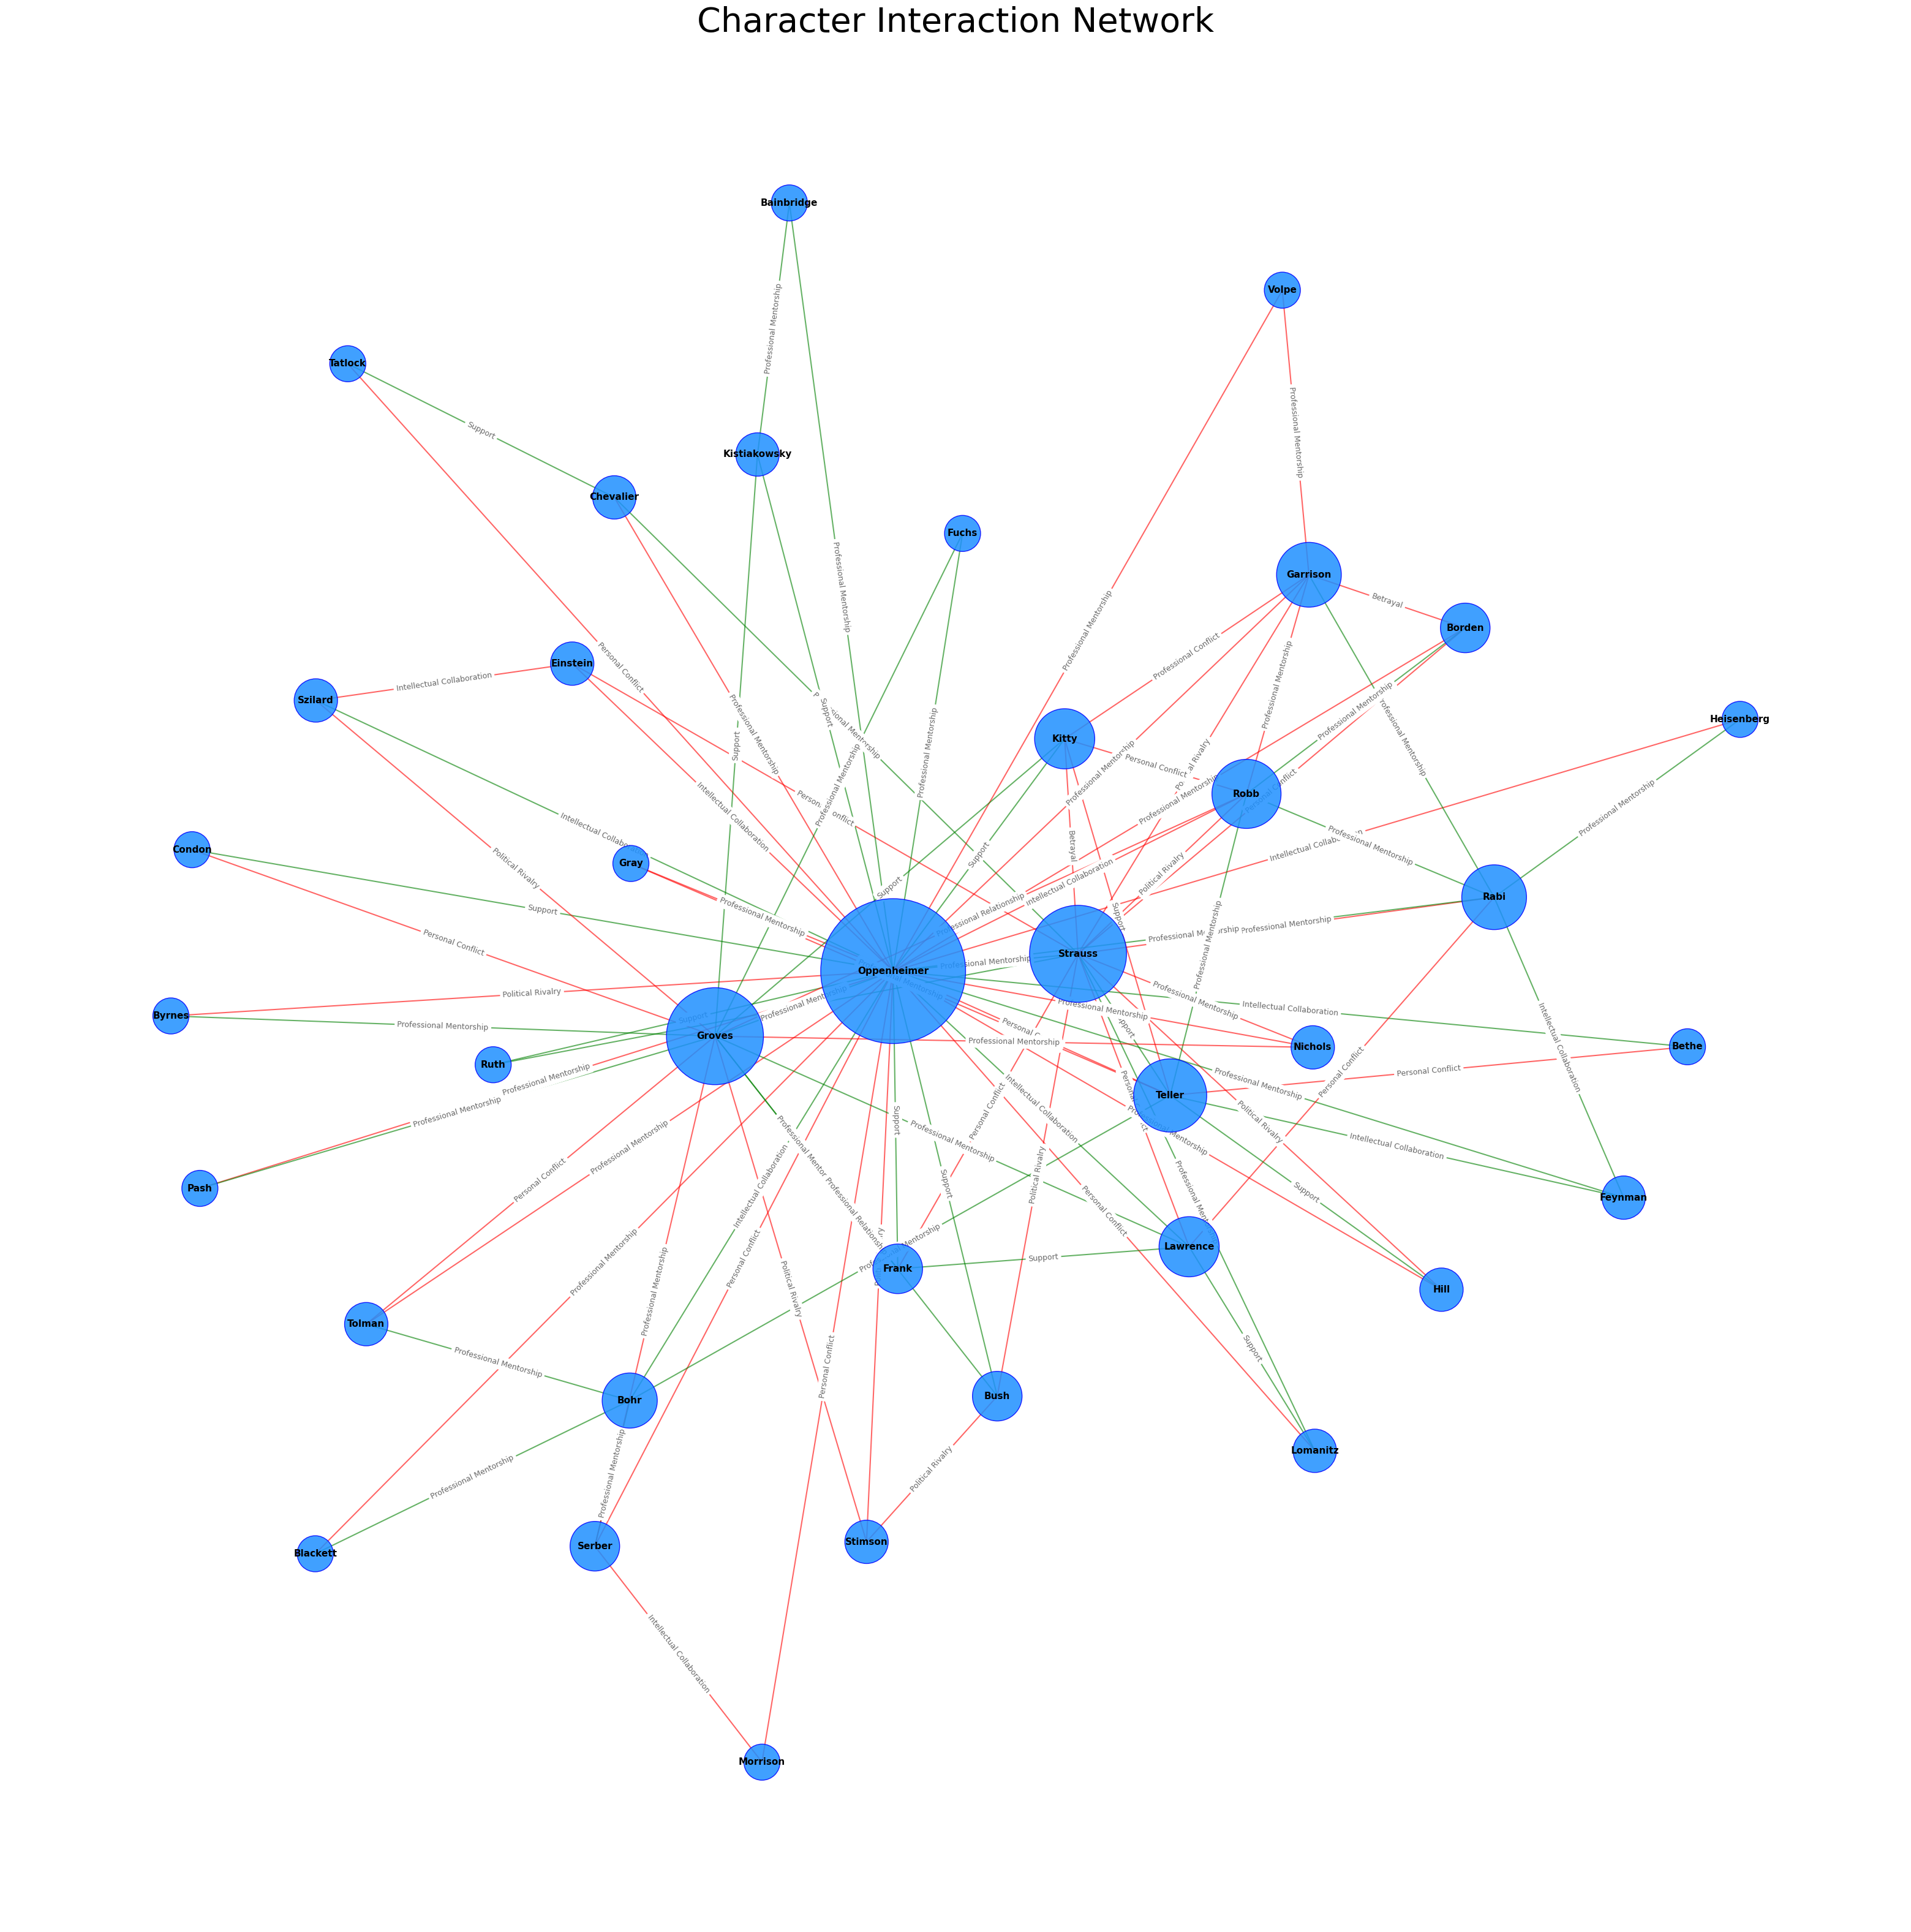

In [40]:
# Create a graph
G = nx.Graph()

# Add edges to the graph, filtering out self-loops
for edge in standardized_data:
    from_character = edge['from']
    to_character = edge['to']
    relationship_type = edge['type']
    theme = edge['theme_type']
    sentiment = edge['sentiment']  # Get sentiment for coloring

    # Only add edges where from_character and to_character are different
    if from_character != to_character:
        G.add_edge(from_character, to_character, type=relationship_type, theme=theme, sentiment=sentiment)

# Remove nodes with only one connection (degree of 1)
nodes_to_remove = [node for node, degree in G.degree() if degree == 1]
G.remove_nodes_from(nodes_to_remove)

# Calculate node sizes based on degree centrality for the remaining graph
node_sizes = [200 + 800 * nx.degree(G, n) for n in G.nodes()]  # Adjust multiplier for visibility

# Prepare edge colors based on sentiment
edge_colors = ['green' if G[u][v]['sentiment'] == 'Positive' else 'red' for u, v in G.edges()]

# Plotting the network
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G, k=0.5, seed=42)

# Draw nodes with customized size and color
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='dodgerblue', edgecolors='blue', alpha=0.85)

nx.draw_networkx_edges(
    G, pos,
    width=1.5,
    alpha=0.6,
    edge_color=edge_colors
)

# Draw labels for nodes with increased font size
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

# Add edge labels for relationship types

edge_labels = nx.get_edge_attributes(G, 'type')
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=edge_labels,
    font_size=9,
    font_color="dimgray"
)

plt.title("Character Interaction Network", fontsize=40)
plt.axis("off")
plt.show()


In [41]:
# Calculate graph metrics: density, average degree, total nodes, and total edges

# Density of the graph
density = nx.density(G)

# Total number of nodes in the graph
total_nodes = G.number_of_nodes()

# Total number of edges in the graph
total_edges = G.number_of_edges()

# Calculate average degree (sum of degrees of all nodes divided by the total number of nodes)
average_degree = sum(dict(G.degree()).values()) / total_nodes

# Display graph metrics
print(f"Graph Density: {density:.4f}")
print(f"Total Number of Nodes: {total_nodes}")
print(f"Total Number of Edges: {total_edges}")
print(f"Average Degree: {average_degree:.2f}")

Graph Density: 0.1411
Total Number of Nodes: 37
Total Number of Edges: 94
Average Degree: 5.08


Graph Density: 0.0574

Explanation: Graph density measures the ratio of actual edges to the maximum possible edges in a graph. It provides insight into how densely connected the network is.
Interpretation: A density of 0.0574 means that only about 5.74% of all possible edges between nodes are present. This indicates a relatively sparse network, where most nodes are not directly connected to many other nodes.
Total Number of Nodes: 67

Explanation: This represents the total number of nodes (or vertices) in the graph.
Interpretation: The graph contains 67 unique entities, which could represent individuals, objects, or any entities being connected in this network.
Total Number of Edges: 127

Explanation: This is the total number of edges (connections) between nodes in the graph.
Interpretation: There are 127 connections among the 67 nodes. Each edge represents a relationship or interaction between two nodes.
Average Degree: 3.79

Explanation: The average degree is the average number of connections (edges) per node. It’s calculated as the total number of edges divided by the number of nodes.
Interpretation: On average, each node has about 3.79 connections. This provides insight into the level of connectivity within the network, showing that nodes tend to have a few connections rather than being highly interconnected.

In [42]:
# Calculate centrality measures
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Create a summary of centrality measures
centrality_summary = {
    "Character": [],
    "Degree Centrality": [],
    "Betweenness Centrality": [],
    "Eigenvector Centrality": []
}

for character in G.nodes():
    centrality_summary["Character"].append(character)
    centrality_summary["Degree Centrality"].append(degree_centrality[character])
    centrality_summary["Betweenness Centrality"].append(betweenness_centrality[character])
    centrality_summary["Eigenvector Centrality"].append(eigenvector_centrality[character])

# Convert to a DataFrame for better display
centrality_df = pd.DataFrame(centrality_summary)

# Sort the DataFrame by Degree Centrality and get the top 10
centrality_df = centrality_df.sort_values(by="Degree Centrality", ascending=False).head(10)

# Display the top 10 in a nicely formatted table
print(centrality_df.to_string(index=False))

  Character  Degree Centrality  Betweenness Centrality  Eigenvector Centrality
Oppenheimer           1.000000                0.712396                0.527113
    Strauss           0.444444                0.065608                0.321710
     Groves           0.444444                0.077116                0.278776
     Teller           0.250000                0.017989                0.203241
       Robb           0.222222                0.005121                0.233543
       Rabi           0.194444                0.007540                0.186406
   Garrison           0.194444                0.005159                0.192697
   Lawrence           0.166667                0.003137                0.179537
      Kitty           0.166667                0.001682                0.199725
       Bohr           0.138889                0.004497                0.116094


### Centrality Measures Analysis

This table summarizes the centrality measures for the top characters in the interaction network:

- `Degree Centrality` indicates how well-connected each character is, with Oppenheimer being the most central figure.
- `Betweenness Centrality`measures the extent to which a character lies on paths between others, highlighting Oppenheimer's major influence and Strauss' intermediary role.
- `Eigenvector Centrality` ranks Oppenheimer highest, suggesting his importance is not only due to direct connections but also because he is connected to other influential characters, with Groves and Strauss also having substantial influence within the network.


# Community Detection

- In this section, we apply community detection to the character interaction network to identify clusters of closely connected characters.
- Using the Louvain algorithm, we detect distinct communities in the graph, which can reveal groups of characters that interact more frequently.
- We then visualize the network with each node colored according to its community, providing insights into the structure and relationships within the character network.

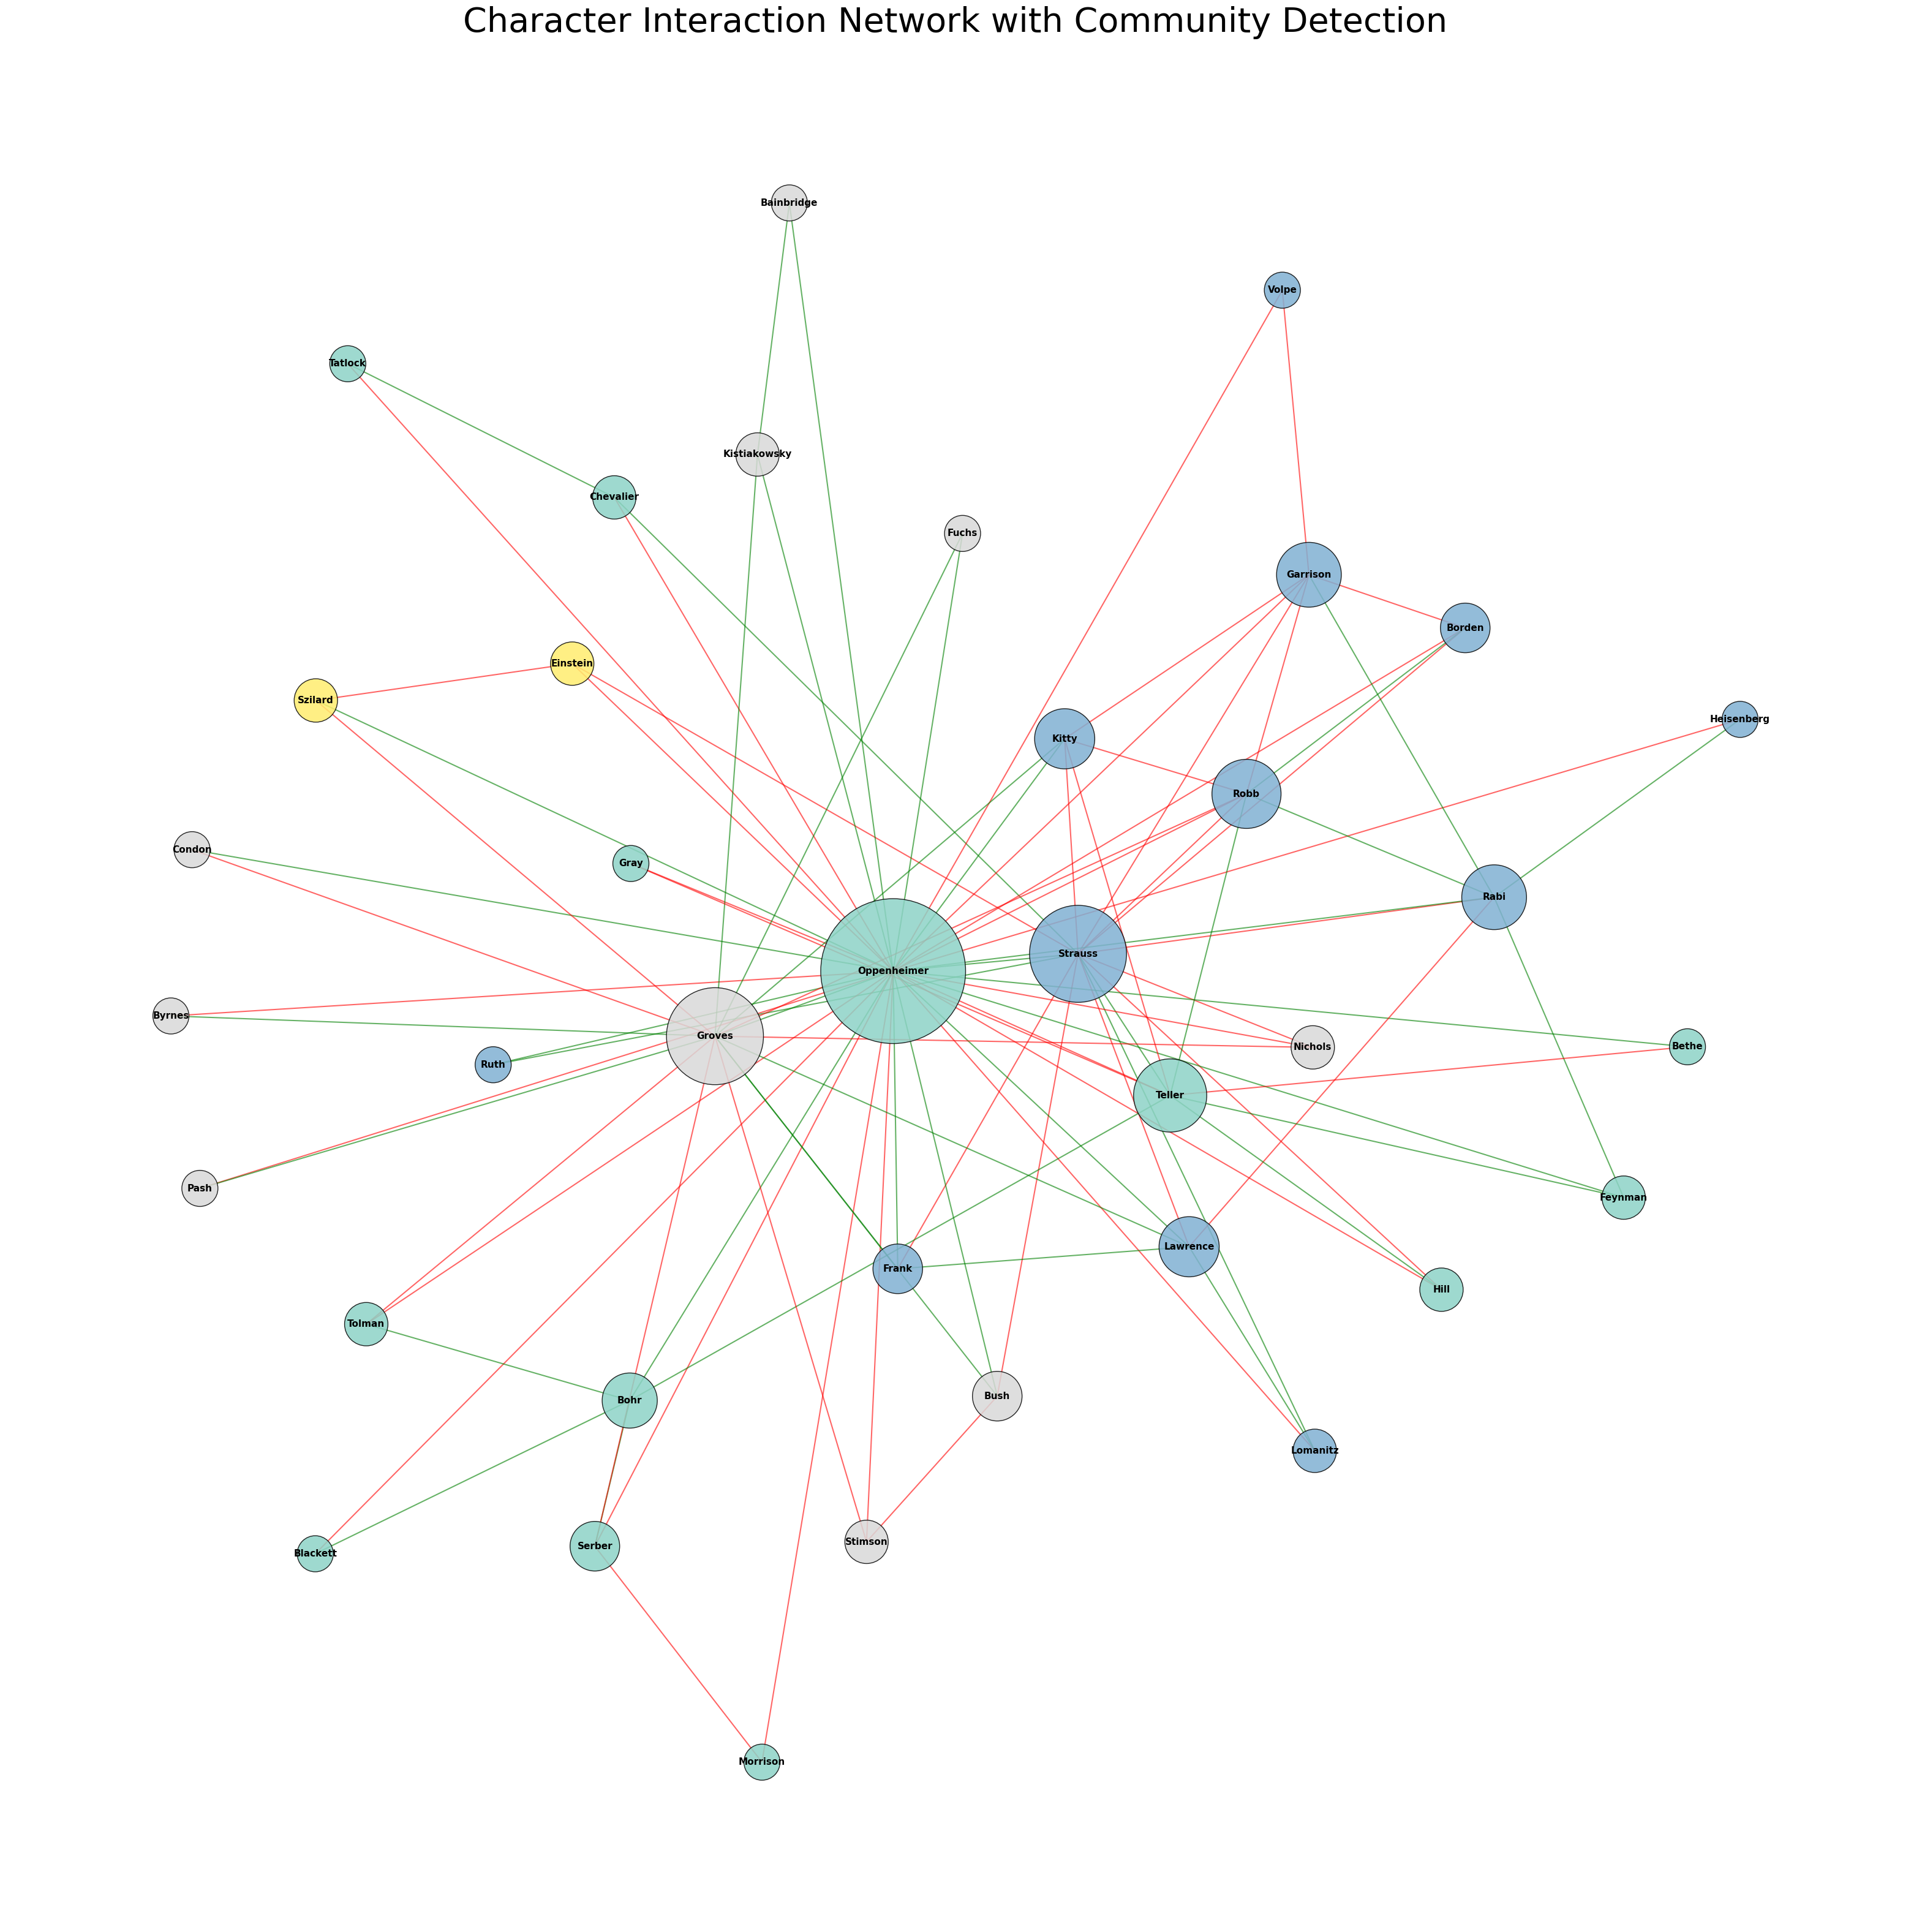

In [43]:
# Detect communities
communities = algorithms.louvain(G)

# Extract communities as a dictionary for each node
partition = {node: cid for cid, community in enumerate(communities.communities) for node in community}

# Map each node to its community color
community_colors = [partition[node] for node in G.nodes()]

# Plot the network with community coloring
plt.figure(figsize=(40, 40))
pos = nx.spring_layout(G, k=0.5, seed=42)
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=community_colors, cmap=plt.cm.Set3, edgecolors='black', alpha=0.85)
nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.6, edge_color=edge_colors)
nx.draw_networkx_labels(G, pos, font_size=11, font_weight="bold")

plt.title("Character Interaction Network with Community Detection", fontsize=40)
plt.axis("off")
plt.show()

In [44]:
# Standardize case for theme and type counts per community
for cid in set(partition.values()):
    # Filter edges within the current community
    community_edges = [
        (u, v, standardized_data) for u, v, standardized_data in G.edges(data=True) 
        if partition[u] == cid and partition[v] == cid
    ]

    # Count themes and relationship types with consistent case
    theme_counts = Counter(standardized_data['theme_type'].title() for _, _, standardized_data in community_edges if 'theme_type' in standardized_data)
    relationship_counts = Counter(standardized_data['type'].title() for _, _, standardized_data in community_edges if 'type' in standardized_data)
    sentiment_counts= Counter((standardized_data['sentiment'].title() for _, _, standardized_data in community_edges if 'sentiment' in standardized_data))
    place_counts=Counter((standardized_data['place'].title() for _, _, standardized_data in community_edges if 'place' in standardized_data))

    print(f"\nCommunity {cid} - Top Themes:", theme_counts.most_common(1))
    print(f"Community {cid} - Top Relationships:", relationship_counts.most_common(1))
    print(f"Community {cid} - Top Sentiment:", sentiment_counts.most_common(1))
    print(f"Community {cid} - Top Sentiment:", place_counts.most_common(1))




Community 0 - Top Themes: []
Community 0 - Top Relationships: [('Professional Mentorship', 11)]
Community 0 - Top Sentiment: [('Negative', 10)]
Community 0 - Top Sentiment: []

Community 1 - Top Themes: []
Community 1 - Top Relationships: [('Professional Mentorship', 8)]
Community 1 - Top Sentiment: [('Negative', 13)]
Community 1 - Top Sentiment: []

Community 2 - Top Themes: []
Community 2 - Top Relationships: [('Professional Mentorship', 5)]
Community 2 - Top Sentiment: [('Positive', 6)]
Community 2 - Top Sentiment: []

Community 3 - Top Themes: []
Community 3 - Top Relationships: [('Intellectual Collaboration', 1)]
Community 3 - Top Sentiment: [('Negative', 1)]
Community 3 - Top Sentiment: []


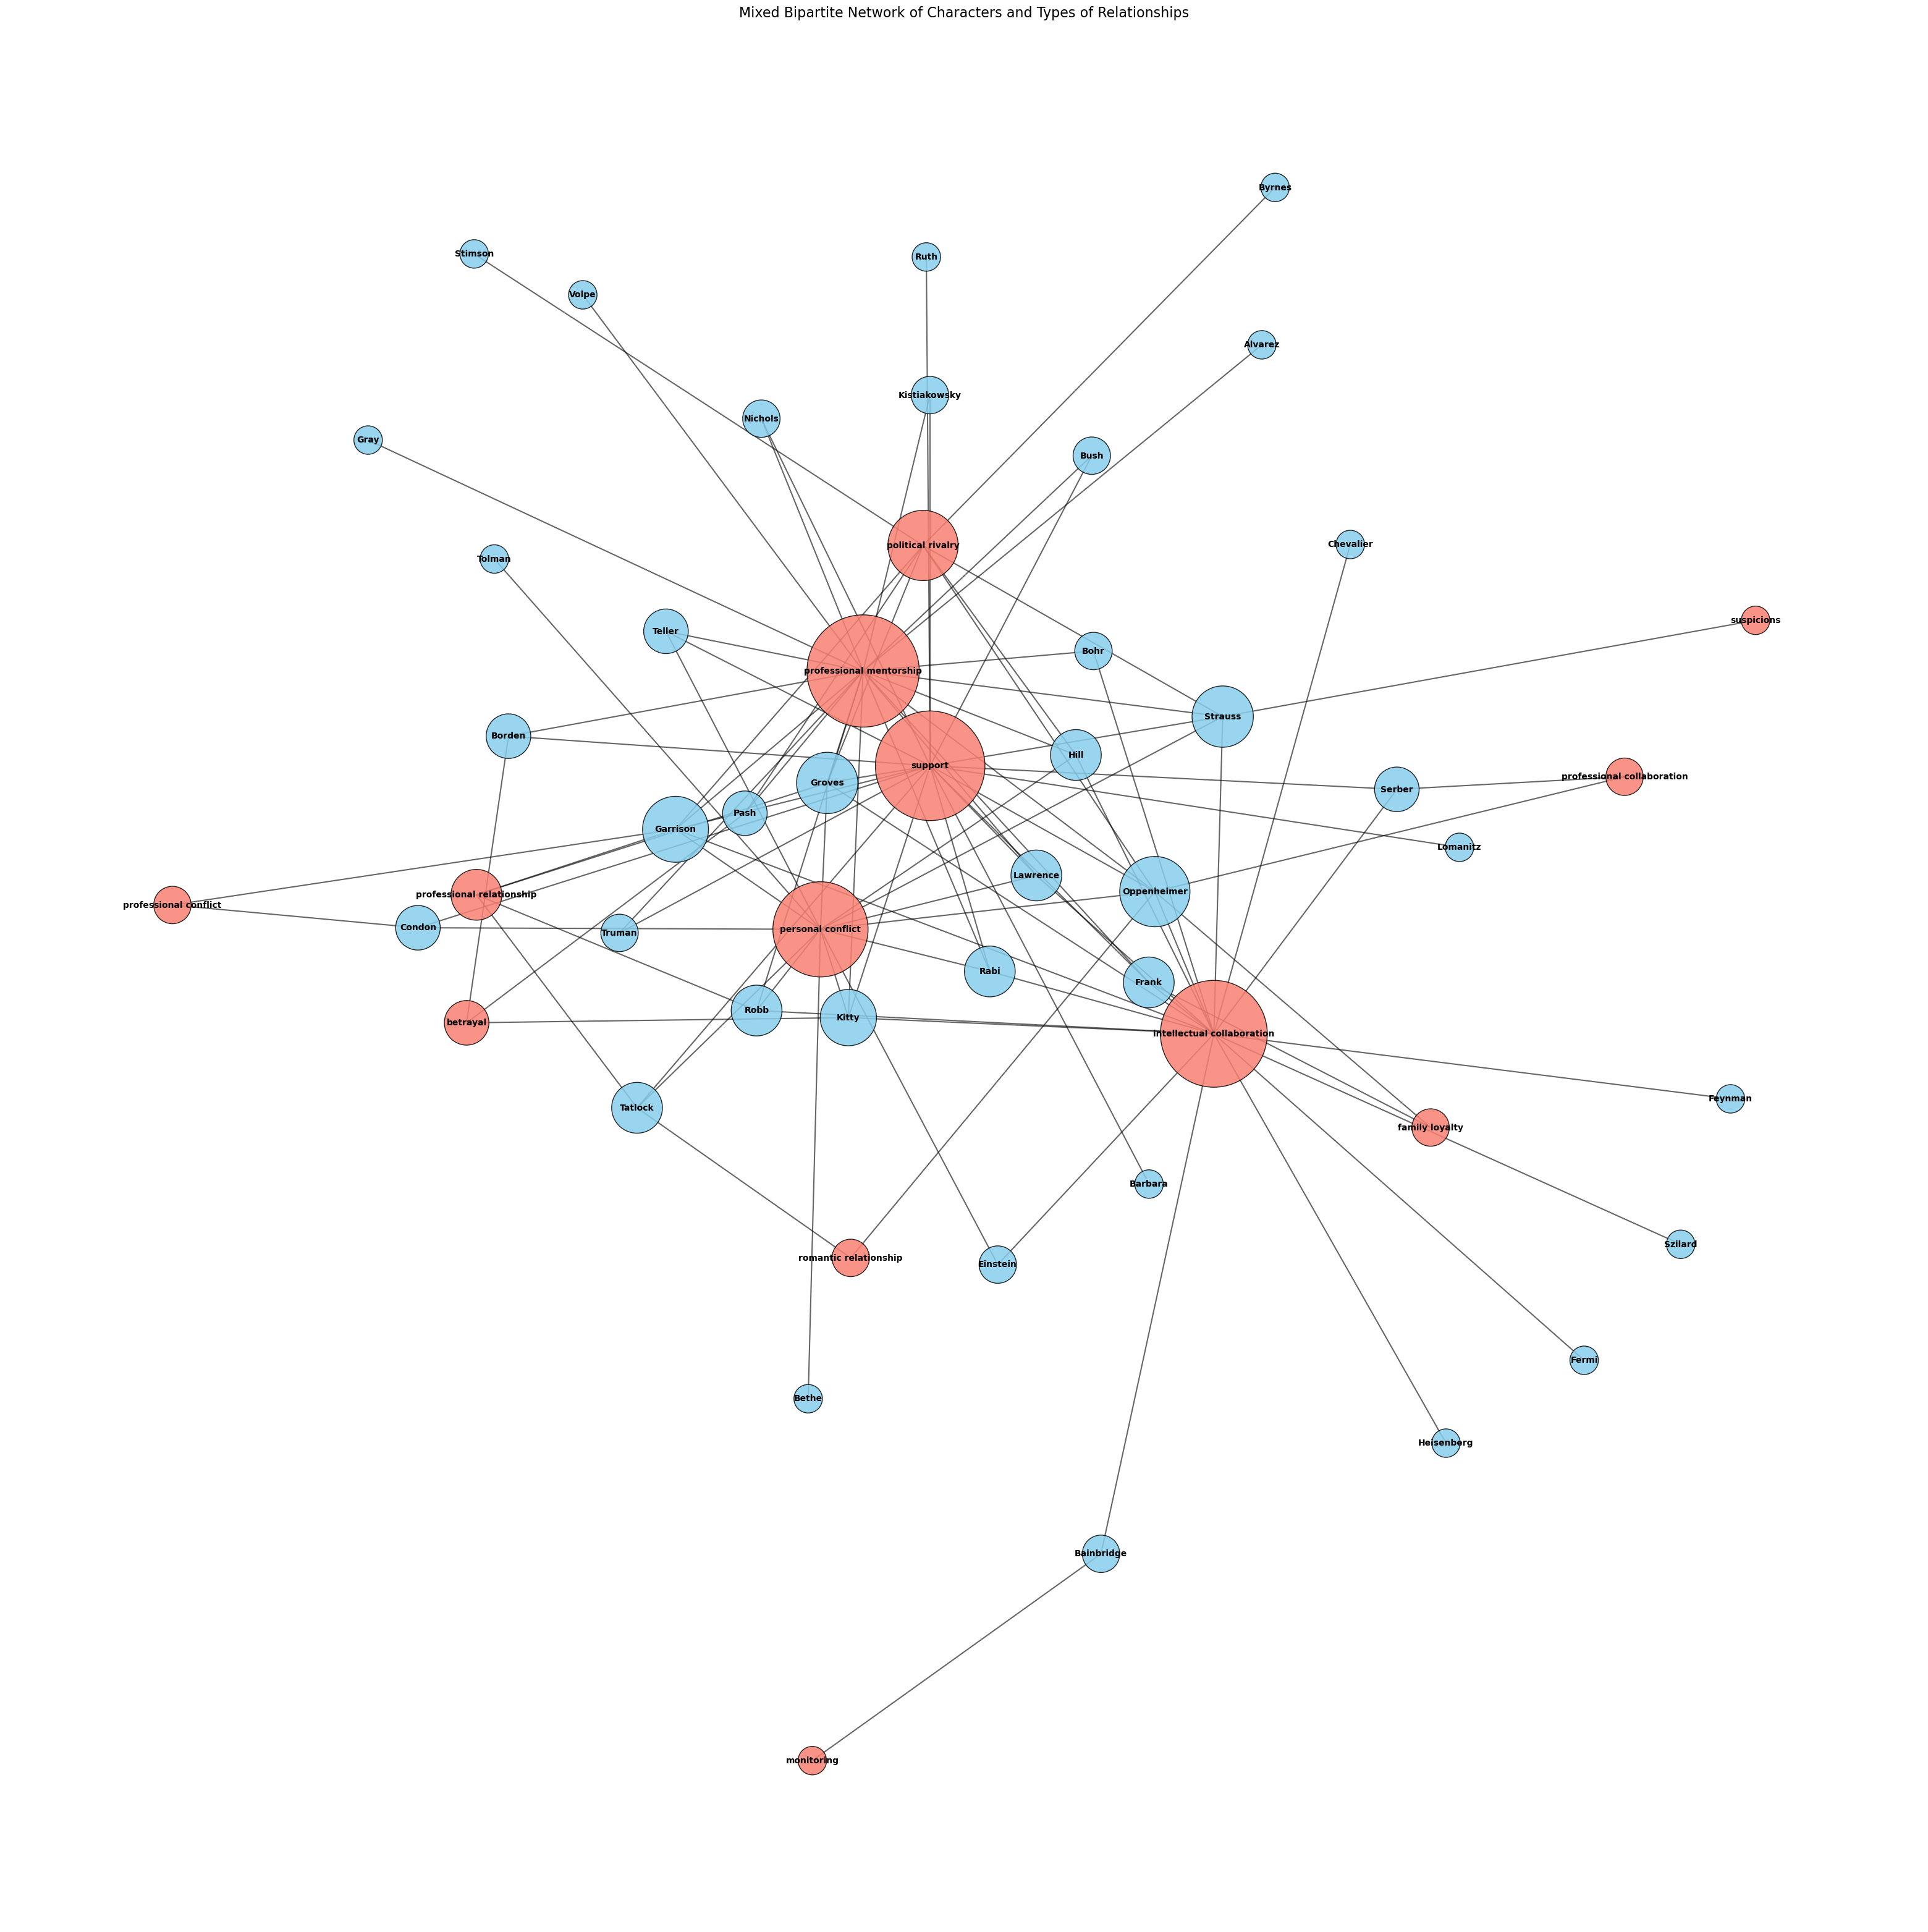

In [45]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a bipartite graph
B = nx.Graph()

# Add edges to the graph, using "from" characters and "type" as two different types of nodes
for edge in standardized_data:
    from_character = edge['from']
    type = edge['type']



    # Add "from" character as one type of node (bipartite=0)
    B.add_node(from_character, bipartite=0)

    # Add type as another type of node (bipartite=1), ensuring it's case-insensitive
    type_node = type.lower()
    B.add_node(type_node, bipartite=1)

    B.add_edge(
        from_character,
        type_node,

    )

# Calculate node sizes based on degree for visualization
node_sizes = [300 + 800 * B.degree(n) for n in B.nodes()]

# Prepare edge colors based on relationship type or theme if needed
edge_colors = ['black'

]

# Set up a random layout to mix nodes (no bipartite separation)
pos = nx.spring_layout(B, k=0.5, seed=42)  # spring_layout creates a mixed arrangement

# Plotting the bipartite network
plt.figure(figsize=(40, 40))

# Draw nodes with size and color based on their type
nx.draw_networkx_nodes(
    B, pos, node_size=node_sizes, 
    node_color=['skyblue' if B.nodes[n]["bipartite"] == 0 else 'salmon' for n in B.nodes()],
    edgecolors='black', alpha=0.85
)

# Draw edges with colors based on relationship type or other attributes
nx.draw_networkx_edges(
    B, pos,
    width=1.5,
    alpha=0.6,
    edge_color=edge_colors
)

# Draw labels for nodes
nx.draw_networkx_labels(B, pos, font_size=10, font_weight="bold")

# Ensure edge_labels dictionary contains only edges that exist in the graph
edge_labels = {(u, v): label for (u, v), label in edge_labels.items() if B.has_edge(u, v)}

# Draw edge labels for existing edges only
nx.draw_networkx_edge_labels(
    B, pos,
    edge_labels=edge_labels,
    font_size=8,
    font_color="gray"
)


plt.title("Mixed Bipartite Network of Characters and Types of Relationships", fontsize=16)
plt.axis("off")
plt.show()

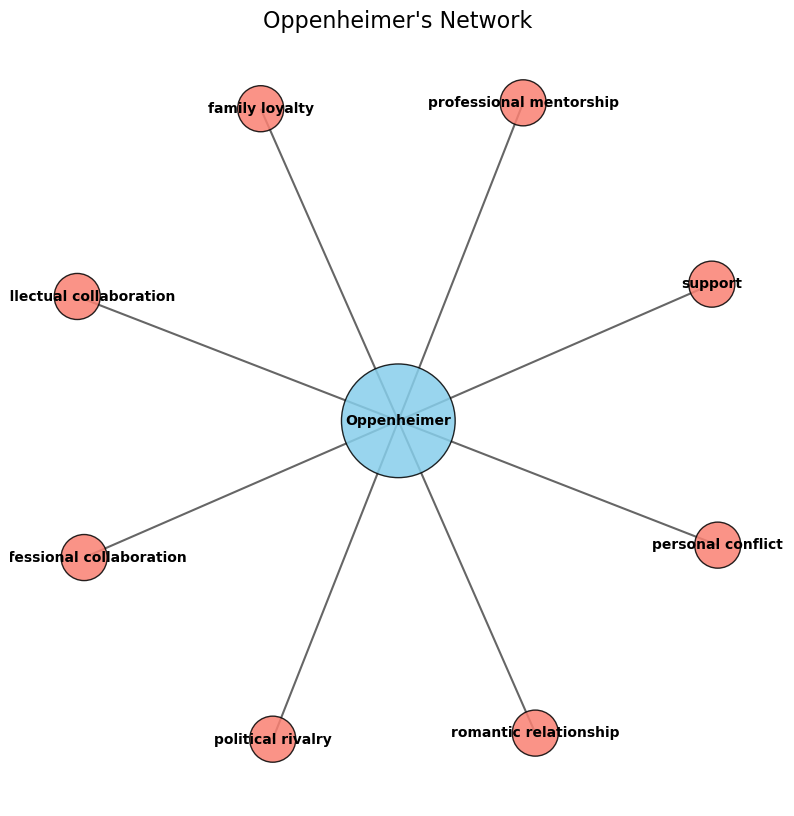

In [46]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize a subgraph for Oppenheimer's network
oppenheimer_network = nx.Graph()

# Filter nodes and edges connected to "Oppenheimer"
for edge in B.edges(data=True):
    u, v, attributes = edge
    if "oppenheimer" in [u.lower(), v.lower()]:  # Check if Oppenheimer is one of the nodes
        oppenheimer_network.add_edge(u, v, **attributes)

# Visualization for Oppenheimer's Network
plt.figure(figsize=(10, 10))
pos = nx.spring_layout(oppenheimer_network, k=0.5, seed=42)
node_sizes = [300 + 800 * oppenheimer_network.degree(n) for n in oppenheimer_network.nodes()]

nx.draw_networkx_nodes(
    oppenheimer_network, pos, node_size=node_sizes, 
    node_color=['skyblue' if B.nodes[n]["bipartite"] == 0 else 'salmon' for n in oppenheimer_network.nodes()],
    edgecolors='black', alpha=0.85
)
nx.draw_networkx_edges(oppenheimer_network, pos, width=1.5, alpha=0.6, edge_color='black')
nx.draw_networkx_labels(oppenheimer_network, pos, font_size=10, font_weight="bold")
plt.title("Oppenheimer's Network", fontsize=16)
plt.axis("off")
plt.show()
